# Logistic Regression

This notebook builds a logistic regression classifier:
- Derives the cross-entropy loss from the Bernoulli likelihood
- Implements gradient descent to optimize the logistic model
- Visualizes the loss surface and training trajectories
- Plots decision boundaries on synthetic datasets to illustrate classification

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

## MLE for Logistic Regression with Bernoulli Likelihood

We're modeling binary outputs $y \in \{0, 1\}^n$ as probabilistic functions of inputs $X \in \mathbb{R}^{n \times d}$:

$$
p(y_i \mid x_i, w) = \sigma(x_i^T w)^{y_i} (1 - \sigma(x_i^T w))^{1 - y_i}
$$

Where:
- $x_i \in \mathbb{R}^d$ is the $i$-th row of $X$, representing one data point  
- $w \in \mathbb{R}^d$ is the parameter vector  
- $y_i \in \{0, 1\}$ is the label for $x_i$  
- $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function, mapping real values to probabilities  

The outputs are independent Bernoulli random variables conditioned on $X$:  

$$
y_i \mid x_i \sim \text{Bernoulli}(\sigma(x_i^T w))
$$

This model directly estimates the probability of $y_i = 1$ given $x_i$, rather than fitting the outputs with Gaussian noise as in linear regression.


### Deriving the Cross-Entropy Loss

From the Bernoulli model, each data point has likelihood:

$$
p(y_i \mid x_i, w) = \sigma(x_i^T w)^{y_i} (1 - \sigma(x_i^T w))^{1 - y_i}
$$

Assuming the $n$ samples are independent, the joint likelihood is:

$$
L(w) = \prod_{i=1}^n p(y_i \mid x_i, w)
     = \prod_{i=1}^n \sigma(x_i^T w)^{y_i} (1 - \sigma(x_i^T w))^{1 - y_i}
$$

Taking the log gives the log-likelihood:

$$
\ell(w) = \sum_{i=1}^n \Big[ y_i \log \sigma(x_i^T w) + (1 - y_i) \log (1 - \sigma(x_i^T w)) \Big]
$$

Maximizing this log-likelihood is equivalent to minimizing the **negative log-likelihood (NLL)**:

$$
\mathcal{L}(w) = -\ell(w) = -\sum_{i=1}^n \Big[ y_i \log \sigma(x_i^T w) + (1 - y_i) \log (1 - \sigma(x_i^T w)) \Big]
$$

This is the **binary cross-entropy loss**:

$$
\mathcal{L}(w) = \text{CrossEntropy}(y, \hat{y}) \quad\text{with}\quad \hat{y}_i = \sigma(x_i^T w)
$$

Intuitively, the loss penalizes the model whenever the predicted probability $\sigma(x_i^T w)$ deviates from the true label $y_i$, pushing predictions toward 1 when $y_i = 1$ and toward 0 when $y_i = 0$.

Thus, cross-entropy directly measures how well the predicted probabilities $\hat{y}_i$ match the true binary outcomes.


In [3]:
# Set number of continuous features
n_features = 2

# Generate true weights
w_true = np.array([1.0, -1.0])  # np.random.randn(n_features)
print("w_true:", w_true)

# Generate random samples
n_samples = 1000
X = np.random.randn(n_samples, n_features)

# Generate labels according to logistic model
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Draw labels from Bernoulli distribution
probs = sigmoid(X @ w_true)
y = np.random.binomial(1, probs)

# Negative log-likelihood gradient
def logistic_regression_gradient(w, X, y):
    preds = sigmoid(X @ w)
    grad = X.T @ (preds - y) / len(y)
    return grad

# Fit weights using gradient descent
w_grad = np.zeros(n_features)
learning_rate = 0.1
for i in range(1000):
    grad_vec = logistic_regression_gradient(w_grad, X, y)
    w_grad -= learning_rate * grad_vec

print("w_grad:", w_grad)


w_true: [ 1. -1.]
w_grad: [ 0.884 -0.935]


### Visualize Loss Surface and Training Trajectories

We visualize the negative log-likelihood loss surface as a function of the two weight parameters. The contour plot shows how the loss changes across weight space, and the red markers trace the path of gradient descent as it converges toward the optimum.

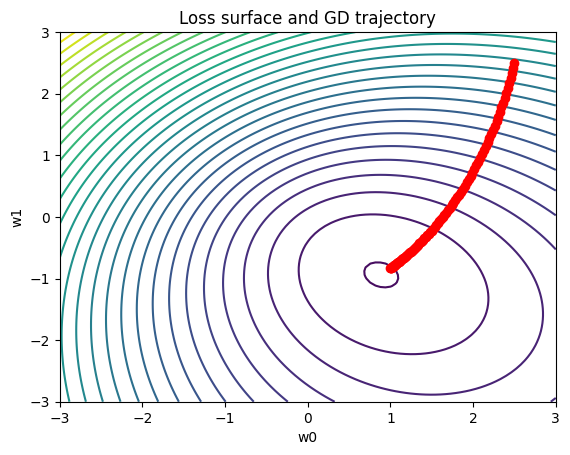

In [5]:
# Define loss function
def logistic_loss(w, X, y):
    preds = sigmoid(X @ w)
    # add a small epsilon for numerical stability
    eps = 1e-9
    return -np.mean(y * np.log(preds + eps) + (1 - y) * np.log(1 - preds + eps))

# Grid over 2D weight space
w0 = np.linspace(-3, 3, 100)
w1 = np.linspace(-3, 3, 100)
W0, W1 = np.meshgrid(w0, w1)
Z = np.zeros_like(W0)

for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        w = np.array([W0[i, j], W1[i, j]])
        Z[i, j] = logistic_loss(w, X, y)

# Run gradient descent and track path
w = np.array([2.5, 2.5])
trajectory = [w.copy()]
learning_rate = 0.2
for _ in range(100):
    grad = logistic_regression_gradient(w, X, y)
    w -= learning_rate * grad
    trajectory.append(w.copy())
trajectory = np.array(trajectory)

# Plot loss surface with trajectory
plt.contour(W0, W1, Z, levels=30, cmap="viridis")
plt.plot(trajectory[:,0], trajectory[:,1], marker="o", color="red")
plt.title("Loss surface and GD trajectory")
plt.xlabel("w0")
plt.ylabel("w1")
plt.show()

### Decision Boundaries on Two Moons

We plot the learned decision boundary of the logistic regression classifier on a 2D synthetic dataset. The background colors show predicted probabilities, while the points show the actual data colored by class label.

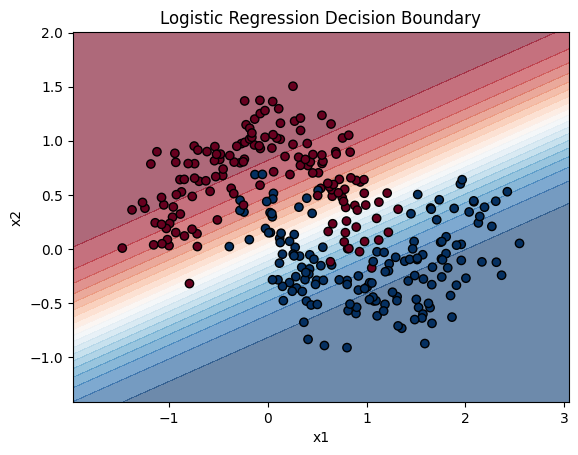

In [9]:
from sklearn.datasets import make_moons

# Generate 2D synthetic dataset
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)

# Train logistic regression with GD
w = np.zeros(X.shape[1])
lr = 0.1
for _ in range(1000):
    grad = logistic_regression_gradient(w, X, y)
    w -= lr * grad

# Plot decision boundary
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
                     np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = sigmoid(grid @ w).reshape(xx.shape)

plt.contourf(xx, yy, probs, levels=20, cmap="RdBu", alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap="RdBu", edgecolors="k")
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()
